# **Helper Functions & Imports**

## **Import**

In [228]:
!pip install --upgrade torch torchvision torchaudio

In [229]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
import random
import io
import base64
from google.colab import drive
from torchvision.models.resnet import ResNet18_Weights
# Mount Google Drive at the start
drive.mount('/content/drive')

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


## **Create seed dataset**

In [230]:
class SeedDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.samples = []
        for label_dir in ['BadSeed', 'GoodSeed']:
            class_idx = 0 if label_dir == 'BadSeed' else 1
            folder = os.path.join(root_dir, label_dir)
            for fname in os.listdir(folder):
                if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.samples.append((os.path.join(folder, fname), class_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

## **Create seed test dataset**

In [231]:
class SeedTestDataset(Dataset):
    def __init__(self, transform=None):
        """
        Initialize dataset with for Batch2 and Batch3.

        Args:
            transform: Optional transforms to be applied to images
        """
        self.transform = transform
        self.samples = []

        # Batch2 and Batch3
        batch2_dir = '/content/drive/My Drive/Computer_Vision/Batch2'
        batch2_csv = '/content/drive/My Drive/Computer_Vision/Batch2/NormalRoomLight_annotation.csv'
        batch3_dir = '/content/drive/My Drive/Computer_Vision/Batch3'
        batch3_csv = '/content/drive/My Drive/Computer_Vision/Batch3/LightBox_annotation.csv'

        # Load data from both batches
        self._load_batch(batch2_dir, batch2_csv)
        self._load_batch(batch3_dir, batch3_csv)

        print(f"Total samples loaded: {len(self.samples)}")

    def _load_batch(self, batch_dir, csv_path):
        """
        Helper function to load samples from a specific batch.

        Args:
            batch_dir: Directory path for the batch
            csv_path: Path to the CSV file with annotations
        """
        # Read the CSV file with annotations
        df = pd.read_csv(csv_path)

        # Track any path issues
        issues_found = 0
        batch_name = os.path.basename(batch_dir)

        for _, row in df.iterrows():
            file_name = row['file_name']

            # Extract just the Set folder and filename part
            # First, try to find "Set" in the path
            if "Set" in file_name:
                # Find the position where "Set" appears in the path
                set_idx = file_name.find("Set")
                # Extract everything from "Set" onwards
                relative_path = file_name[set_idx:]
            else:
                # As a fallback, take the last two parts of the path
                path_parts = file_name.split('/')
                relative_path = '/'.join(path_parts[-2:]) if len(path_parts) >= 2 else path_parts[-1]

            # Handle case sensitivity in file extensions
            base, ext = os.path.splitext(relative_path)
            if ext.lower() == '.jpg':
                # Try both .JPG and .jpg extensions
                paths_to_try = [
                    os.path.join(batch_dir, base + '.JPG'),
                    os.path.join(batch_dir, base + '.jpg'),
                    os.path.join(batch_dir, relative_path)  # Original as fallback
                ]
            else:
                # For other extensions, try uppercase and lowercase
                paths_to_try = [
                    os.path.join(batch_dir, relative_path),
                    os.path.join(batch_dir, base + ext.upper()),
                    os.path.join(batch_dir, base + ext.lower())
                ]

            # Find the first path that exists
            img_path = None
            for path in paths_to_try:
                if os.path.exists(path):
                    img_path = path
                    break

            # If no valid path found, use the first one and log warning
            if img_path is None:
                img_path = paths_to_try[0]
                issues_found += 1
                if issues_found <= 5:  # Limit warnings to prevent console spam
                    print(f"Warning ({batch_name}): Could not find file at any of these paths:")
                    for p in paths_to_try:
                        print(f"  - {p}")

            # Parse bounding box coordinates
            xmin = int(row['x_min'])
            ymin = int(row['y_min'])
            xmax = int(row['x_max'])
            ymax = int(row['y_max'])

            # Determine label
            label = 1 if 'GOOD' in row['bbox_label'] else 0

            # Store batch information along with the sample
            self.samples.append((img_path, (xmin, ymin, xmax, ymax), label, batch_name))

        if issues_found > 0:
            print(f"{batch_name}: Total of {issues_found} file path issues found. Some images may not load correctly.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, (xmin, ymin, xmax, ymax), label, _ = self.samples[idx]
        try:
            image = Image.open(img_path).convert('RGB')
            crop = image.crop((xmin, ymin, xmax, ymax))
            if self.transform:
                crop = self.transform(crop)
            return crop, label
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a dummy image and the label in case of error
            if self.transform:
                dummy = torch.zeros(3, 224, 224)
                return dummy, label
            else:
                dummy = Image.new('RGB', (224, 224), color='black')
                return dummy, label

    def get_original_image(self, idx):
        img_path, (xmin, ymin, xmax, ymax), label, _ = self.samples[idx]
        try:
            image = Image.open(img_path).convert('RGB')
            crop = image.crop((xmin, ymin, xmax, ymax))
            return crop, label
        except Exception as e:
            print(f"Error loading original image {img_path}: {e}")
            # Return a dummy image and the label in case of error
            dummy = Image.new('RGB', (224, 224), color='black')
            return dummy, label

    def get_batch_name(self, idx):
        """
        Get the batch name for a specific sample.

        Args:
            idx: Index of the sample

        Returns:
            Name of the batch this sample belongs to
        """
        return self.samples[idx][3]

## **Base model training**

In [232]:
from torch.utils.data import random_split
def train_base_model(data_root: str,
                     num_epochs: int = 10,
                     batch_size: int = 64,
                     val_split: float = 0.2,
                     num_workers: int = 12,
                     device: str = None) -> str:
    """
    Train a ResNet-18 on the SeedDataset and save the best‐performing model as .pth.

    Args:
        data_root: Path to folder with 'BadSeed' & 'GoodSeed' subdirs.
        num_epochs: Number of epochs to train.
        batch_size: Batch size for training & validation.
        val_split: Fraction of data reserved for validation.
        num_workers: Number of DataLoader workers.
        device: 'cuda' or 'cpu'; auto‐chosen if None.

    Returns:
        model_path: Filepath where the best model weights are saved (.pth).
    """
    # Device setup
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    # Transforms
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
    ])
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
    ])

    # Prepare dataset and splits
    full_ds = SeedDataset(root_dir=data_root, transform=train_transform)
    total = len(full_ds)
    n_val = int(val_split * total)
    n_train = total - n_val
    train_ds, val_ds = random_split(full_ds, [n_train, n_val])
    # override validation transform
    val_ds.dataset.transform = val_transform

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                            num_workers=num_workers, pin_memory=True)

    # Model: base ResNet-18 with new final layer
    model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, 2)
    model = model.to(device)

    # Loss and optimizer (SGD default)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    best_val_acc = 0.0
    model_filename = 'base.pth'
    model_path = os.path.join(data_root, model_filename)

    for epoch in range(1, num_epochs + 1):
        # --- Training ---
        model.train()
        running_corrects = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            preds = outputs.argmax(dim=1)
            running_corrects += (preds == labels).sum().item()
        train_acc = running_corrects / n_train

        # --- Validation ---
        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                preds = outputs.argmax(dim=1)
                val_corrects += (preds == labels).sum().item()
        val_acc = val_corrects / n_val

        print(f"Epoch {epoch}/{num_epochs} — "
              f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        # Save best
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), model_path)

    print(f"\nBest validation accuracy: {best_val_acc:.4f}")
    print(f"Saved best model to: {model_path}")
    return model_path

## **Fine Tune Model**

In [233]:
def fine_tune_model(data_root: str, base_model_path: str, num_epochs: int = 15) -> str:
    """
    Fine-tune a pre-trained seed classification model to improve robustness and generalization.

    This function implements several techniques to address specific issues:
    1. Advanced data augmentation for robustness to transformations
    2. Class-weighted loss to handle imbalance and reduce false positives
    3. Mixup training for better decision boundaries
    4. Noise augmentation to improve robustness to noise
    5. Threshold optimization for precision-recall tradeoff

    Args:
        data_root: Path to folder with 'BadSeed' & 'GoodSeed' subdirs.
        base_model_path: Path to the pre-trained model weights (.pth file).
        num_epochs: Number of epochs for fine-tuning.

    Returns:
        model_path: Filepath where the fine-tuned model weights are saved (.pth).
    """
    import os
    import numpy as np
    import torch
    import torch.nn as nn
    import torch.optim as optim
    import torch.nn.functional as F
    from torch.utils.data import DataLoader, random_split, ConcatDataset
    from torchvision import transforms, models
    from sklearn.metrics import confusion_matrix, precision_recall_curve, f1_score

    class AddGaussianNoise:
        """
        Add Gaussian noise to tensor.
        """
        def __init__(self, mean=0., std=0.1):
            self.mean = mean
            self.std = std

        def __call__(self, tensor):
            noise = torch.randn_like(tensor) * self.std + self.mean
            noisy_tensor = tensor + noise
            return torch.clamp(noisy_tensor, 0, 1)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.2),
    ])

    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    noise_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        AddGaussianNoise(mean=0., std=0.1),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    full_ds = SeedDataset(root_dir=data_root, transform=train_transform)
    noise_ds = SeedDataset(root_dir=data_root, transform=noise_transform)

    class_counts = [0, 0]
    for _, label in full_ds:
        class_counts[label] += 1

    total = sum(class_counts)

    class_weights = [total / (1.5 * class_counts[0]), total / (2.5 * class_counts[1])]
    class_weights = torch.tensor(class_weights, device=device)

    print(f"Class distribution: {class_counts}")
    print(f"Using class weights: {class_weights.tolist()}")

    val_split = 0.2
    n_val = int(val_split * len(full_ds))
    n_train = len(full_ds) - n_val

    torch.manual_seed(42)

    train_ds, val_ds = random_split(full_ds, [n_train, n_val])
    val_ds.dataset.transform = val_transform

    noise_n_train = int(n_train * 0.5)
    noise_indices = torch.randperm(len(noise_ds))[:noise_n_train]
    noise_train_ds = torch.utils.data.Subset(noise_ds, noise_indices)

    combined_train_ds = ConcatDataset([train_ds, noise_train_ds])

    batch_size = 64
    num_workers = 12

    train_loader = DataLoader(
        combined_train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    print(f"Training dataset size: {len(combined_train_ds)}")
    print(f"Validation dataset size: {len(val_ds)}")

    model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, 2)
    model.load_state_dict(torch.load(base_model_path, map_location=device))
    model = model.to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights)

    optimizer = optim.SGD(
        model.parameters(),
        lr=0.001,
        momentum=0.9,
        weight_decay=1e-4
    )

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',
        factor=0.5,
        patience=3
    )

    best_val_acc = 0.0
    best_val_f1 = 0.0
    model_filename = 'fine_tuned.pth'
    model_path = os.path.join(data_root, model_filename)
    best_threshold = 0.5

    def mixup_data(x, y, alpha=0.2):
        """
        Returns mixed inputs, pairs of targets, and lambda.
        """
        if alpha > 0:
            lam = np.random.beta(alpha, alpha)
        else:
            lam = 1

        batch_size = x.size()[0]
        index = torch.randperm(batch_size).to(device)

        mixed_x = lam * x + (1 - lam) * x[index, :]
        y_a, y_b = y, y[index]
        return mixed_x, y_a, y_b, lam

    def mixup_criterion(criterion, pred, y_a, y_b, lam):
        """
        Computes mixup loss.
        """
        return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

    print("Starting fine-tuning process...")
    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        y_true = []
        y_pred = []

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            if np.random.random() < 0.5:
                imgs, labels_a, labels_b, lam = mixup_data(imgs, labels)
                outputs = model(imgs)
                loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
                preds = outputs.argmax(dim=1)
                running_corrects += (preds == labels_a).sum().item() * lam + (preds == labels_b).sum().item() * (1 - lam)
            else:
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                preds = outputs.argmax(dim=1)
                running_corrects += (preds == labels).sum().item()

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * imgs.size(0)

        train_loss = running_loss / len(combined_train_ds)
        train_acc = running_corrects / len(combined_train_ds)
        train_f1 = f1_score(y_true, y_pred, average='weighted') if len(y_true) > 0 else 0.0

        model.eval()
        val_loss = 0.0
        val_corrects = 0
        val_true = []
        val_pred = []
        val_scores = []

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * imgs.size(0)

                scores = F.softmax(outputs, dim=1)
                val_scores.extend(scores[:, 1].cpu().numpy())

                preds = outputs.argmax(dim=1)
                val_corrects += (preds == labels).sum().item()

                val_true.extend(labels.cpu().numpy())
                val_pred.extend(preds.cpu().numpy())

        val_loss = val_loss / len(val_ds)
        val_acc = val_corrects / len(val_ds)
        val_f1 = f1_score(val_true, val_pred, average='weighted')

        scheduler.step(val_f1)

        print(f"Epoch {epoch}/{num_epochs} — "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

        conf_matrix = confusion_matrix(val_true, val_pred)
        print(f"Validation Confusion Matrix:\n{conf_matrix}")

        tn, fp, fn, tp = conf_matrix.ravel()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0

        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")
        print(f"False Positives: {fp}, False Negatives: {fn}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_val_acc = val_acc
            torch.save(model.state_dict(), model_path)
            print(f"New best model saved! (F1: {val_f1:.4f})")

            precisions, recalls, thresholds = precision_recall_curve(
                val_true, val_scores, pos_label=1
            )
            f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
            best_threshold_idx = np.argmax(f1_scores)
            best_threshold = thresholds[best_threshold_idx] if len(thresholds) > best_threshold_idx else 0.5

            print(f"Optimal confidence threshold: {best_threshold:.4f} "
                  f"(Precision: {precisions[best_threshold_idx]:.4f}, "
                  f"Recall: {recalls[best_threshold_idx]:.4f})")

    print(f"\nFine-tuning completed!")
    print(f"Best validation accuracy: {best_val_acc:.4f}, F1 score: {best_val_f1:.4f}")
    print(f"Saved best model to: {model_path}")
    print(f"Recommended confidence threshold: {best_threshold:.4f}")

    threshold_file = os.path.join(data_root, 'threshold.txt')
    with open(threshold_file, 'w') as f:
        f.write(f"{best_threshold}")
    print(f"Saved optimal threshold to: {threshold_file}")

    return model_path

## **Evaluate Model**

In [234]:
def evaluate_model(model_path, threshold=0.5, batch_size=64, return_predictions=False):
    """
    Optimized version of evaluate_model with error analysis capabilities.
    Works with the hardcoded SeedTestDataset class that includes Batch2 and Batch3.
    """
    import os
    from collections import defaultdict

    # Load model
    model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, 2)
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=False))
    model = model.to(device)
    model.eval()

    # Transform
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        normalize
    ])

    # Initialize dataset with hardcoded paths
    dataset = SeedTestDataset(transform=test_transform)

    results = {}
    all_true = []
    all_pred = []
    all_score = []

    # For error analysis
    error_cases = []

    # Get unique batch names from dataset
    batch_names = set(dataset.get_batch_name(i) for i in range(len(dataset)))

    # Initialize results dictionary for each unique batch
    for batch_name in batch_names:
        results[batch_name] = {
            'true_labels': [],
            'pred_labels': [],
            'scores': []
        }

    # Create dataloader
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=12)

    # Progress tracking
    total_batches = len(loader)
    processed_batches = 0

    print(f"Starting evaluation on combined dataset with {len(dataset)} samples...")

    with torch.no_grad():
        for batch_idx, (imgs, labels) in enumerate(loader):
            # Print progress every 10 batches
            processed_batches += 1
            if processed_batches % 10 == 0:
                print(f"Processing batch {processed_batches}/{total_batches}")

            # Process batch with model
            imgs = imgs.to(device)
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            preds = (probs >= threshold).astype(int)

            # Track global results
            all_true.extend(labels)
            all_pred.extend(preds)
            all_score.extend(probs)

            # Identify errors for analysis and track batch-specific results
            for j in range(len(labels)):
                idx = batch_idx * batch_size + j
                if idx < len(dataset):
                    batch_name = dataset.get_batch_name(idx)

                    # Add to batch-specific results
                    results[batch_name]['true_labels'].append(int(labels[j]))
                    results[batch_name]['pred_labels'].append(int(preds[j]))
                    results[batch_name]['scores'].append(float(probs[j]))

                    # Track errors
                    if preds[j] != labels[j]:
                        error_cases.append({
                            'batch': batch_name,
                            'file_path': dataset.samples[idx][0],
                            'true_label': int(labels[j]),
                            'pred_label': int(preds[j]),
                            'confidence': float(probs[j])
                        })

    print(f"Completed evaluation, calculating metrics...")

    # Calculate metrics per batch
    for batch_name in batch_names:
        y_true = results[batch_name]['true_labels']
        y_pred = results[batch_name]['pred_labels']
        y_score = results[batch_name]['scores']

        metrics = {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred),
            'recall': recall_score(y_true, y_pred),
            'f1_score': f1_score(y_true, y_pred),
            'auc': roc_auc_score(y_true, y_score),
            'confusion_matrix': confusion_matrix(y_true, y_pred)
        }

        # Replace the list data with computed metrics
        results[batch_name] = metrics

        # Print metrics summary
        print(f"Results for {batch_name}:")
        for metric, value in metrics.items():
            if metric != 'confusion_matrix':
                print(f"  {metric}: {value:.4f}")
            else:
                print(f"  Confusion Matrix:\n{value}")

    # Calculate overall metrics
    print("Calculating overall metrics...")
    results['overall'] = {
        'accuracy': accuracy_score(all_true, all_pred),
        'precision': precision_score(all_true, all_pred),
        'recall': recall_score(all_true, all_pred),
        'f1_score': f1_score(all_true, all_pred),
        'auc': roc_auc_score(all_true, all_score),
        'confusion_matrix': confusion_matrix(all_true, all_pred)
    }

    # Print overall metrics
    print("Overall results:")
    for metric, value in results['overall'].items():
        if metric != 'confusion_matrix':
            print(f"  {metric}: {value:.4f}")
        else:
            print(f"  Confusion Matrix:\n{value}")

    # Perform error analysis
    if error_cases:
        print("\n========== ERROR ANALYSIS ==========")

        # 1. Distribution of errors by batch
        batch_errors = defaultdict(int)
        for case in error_cases:
            batch_errors[case['batch']] += 1

        print("Error distribution by batch:")
        for batch, count in batch_errors.items():
            print(f"  {batch}: {count} errors ({count/len(error_cases)*100:.1f}%)")

        # 2. False positives vs false negatives
        fp_count = sum(1 for case in error_cases if case['true_label'] == 0 and case['pred_label'] == 1)
        fn_count = sum(1 for case in error_cases if case['true_label'] == 1 and case['pred_label'] == 0)

        print(f"\nFalse positives: {fp_count} ({fp_count/len(error_cases)*100:.1f}%)")
        print(f"False negatives: {fn_count} ({fn_count/len(error_cases)*100:.1f}%)")

        # 3. Error confidence analysis
        fp_confidence = [case['confidence'] for case in error_cases if case['true_label'] == 0 and case['pred_label'] == 1]
        fn_confidence = [1-case['confidence'] for case in error_cases if case['true_label'] == 1 and case['pred_label'] == 0]

        if fp_confidence:
            print(f"\nFalse positive average confidence: {np.mean(fp_confidence):.4f}")
        if fn_confidence:
            print(f"False negative average confidence: {np.mean(fn_confidence):.4f}")

        # 4. Save list of error cases for further inspection
        error_df = pd.DataFrame(error_cases)
        error_df.to_csv("error_analysis.csv", index=False)
        print("\nError cases saved to 'error_analysis.csv'")

        # 5. Sample visualization of error cases
        print("\nSample error cases:")
        for i, case in enumerate(error_cases[:5]):
            print(f"  - {case['file_path']}: True={case['true_label']}, Pred={case['pred_label']}, Conf={case['confidence']:.4f}")

    if return_predictions:
        return results, (all_true, all_pred, all_score)
    return results

## **Evaluate Robustness**

In [235]:
class AddGaussianNoise(object):
  def __init__(self, mean=0., std=1.):
    self.mean = mean
    self.std = std

  def __call__(self, tensor):
    return tensor + torch.randn(tensor.size()) * self.std + self.mean

In [236]:
def evaluate_robustness(model_path, threshold=0.5, batch_size=64, return_predictions=False):
    """
    Optimized version of evaluate_robustness using the hardcoded SeedTestDataset.
    Tests model performance under various transforms to assess robustness.
    """
    import os

    # Load model
    model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, 2)
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=False))
    model = model.to(device)
    model.eval()  # Important: set to evaluation mode

    # Normalization
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    # Define robustness transforms
    robust_transforms = {
        'translation': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
            transforms.ToTensor(), normalize
        ]),
        'rotation': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomRotation(degrees=30),
            transforms.ToTensor(), normalize
        ]),
        'scaling': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomAffine(degrees=0, scale=(0.8, 1.2)),
            transforms.ToTensor(), normalize
        ]),
        'illumination': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ColorJitter(brightness=0.5),
            transforms.ToTensor(), normalize
        ]),
        'noise': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            AddGaussianNoise(mean=0., std=0.1), normalize
        ])
    }

    results = {}
    all_predictions = {}

    for name, transform in robust_transforms.items():
        print(f"Evaluating robustness for transform: {name}")

        # Initialize the dataset with the current transform
        dataset = SeedTestDataset(transform=transform)

        # Create dataloader
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=12)

        # Get unique batch names for separate reporting
        batch_names = set(dataset.get_batch_name(i) for i in range(len(dataset)))
        batch_results = {batch_name: {'true': [], 'pred': [], 'score': []} for batch_name in batch_names}

        # Track overall results
        y_true_all, y_pred_all, y_score_all = [], [], []

        # Track progress
        total_batches = len(loader)
        processed_batches = 0

        with torch.no_grad():
            for batch_idx, (imgs, labels) in enumerate(loader):
                # Print progress
                processed_batches += 1
                if processed_batches % 10 == 0:
                    print(f"  Processing batch {processed_batches}/{total_batches}")

                # Forward pass
                imgs = imgs.to(device)
                outputs = model(imgs)
                probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
                preds = (probs >= threshold).astype(int)

                # Track overall results
                y_true_all.extend(labels)
                y_pred_all.extend(preds)
                y_score_all.extend(probs)

                # Track batch-specific results
                for j in range(len(labels)):
                    idx = batch_idx * batch_size + j
                    if idx < len(dataset):
                        batch_name = dataset.get_batch_name(idx)
                        batch_results[batch_name]['true'].append(int(labels[j]))
                        batch_results[batch_name]['pred'].append(int(preds[j]))
                        batch_results[batch_name]['score'].append(float(probs[j]))

        # Calculate metrics for each batch
        for batch_name in batch_names:
            y_true = batch_results[batch_name]['true']
            y_pred = batch_results[batch_name]['pred']
            y_score = batch_results[batch_name]['score']

            if len(y_true) > 0:
                print(f"  Results for {batch_name} with {name} transform:")
                batch_metrics = {
                    'accuracy': accuracy_score(y_true, y_pred),
                    'precision': precision_score(y_true, y_pred),
                    'recall': recall_score(y_true, y_pred),
                    'f1_score': f1_score(y_true, y_pred),
                    'auc': roc_auc_score(y_true, y_score),
                    'confusion_matrix': confusion_matrix(y_true, y_pred)
                }

                for metric, value in batch_metrics.items():
                    if metric != 'confusion_matrix':
                        print(f"    {metric}: {value:.4f}")

        # Calculate metrics for this transform across all batches
        metrics = {
            'accuracy': accuracy_score(y_true_all, y_pred_all),
            'precision': precision_score(y_true_all, y_pred_all),
            'recall': recall_score(y_true_all, y_pred_all),
            'f1_score': f1_score(y_true_all, y_pred_all),
            'auc': roc_auc_score(y_true_all, y_score_all),
            'confusion_matrix': confusion_matrix(y_true_all, y_pred_all)
        }
        results[name] = metrics

        # Print overall metrics for this transform
        print(f"Overall results for {name}:")
        for metric, value in metrics.items():
            if metric != 'confusion_matrix':
                print(f"  {metric}: {value:.4f}")

        if return_predictions:
            all_predictions[name] = (y_true_all, y_pred_all, y_score_all)

    if return_predictions:
        return results, all_predictions
    return results

## **Visualisation Functions**

### **Display Confusion-Matrices**

In [237]:
def display_batch_results(results, model_name):
    """
    Display the evaluation results in a formatted table.

    Args:
        results: Dictionary containing evaluation metrics
        model_name: Name of the model to display in header
    """
    print(f"\n========== {model_name} EVALUATION RESULTS ==========")

    # First display overall results
    if 'overall' in results:
        print("\nOVERALL RESULTS:")
        metrics = results['overall']
        for metric, value in metrics.items():
            if metric != 'confusion_matrix':
                print(f"  {metric.replace('_', ' ').title()}: {value:.4f}")

        # Print confusion matrix separately with better formatting
        if 'confusion_matrix' in metrics:
            cm = metrics['confusion_matrix']
            print("\n  Confusion Matrix:")
            print(f"    TN: {cm[0, 0]}, FP: {cm[0, 1]}")
            print(f"    FN: {cm[1, 0]}, TP: {cm[1, 1]}")

    # Display results for each batch separately
    for key, metrics in results.items():
        if key != 'overall':
            print(f"\nRESULTS FOR {os.path.basename(key)}:")
            for metric, value in metrics.items():
                if metric != 'confusion_matrix':
                    print(f"  {metric.replace('_', ' ').title()}: {value:.4f}")

            # Print confusion matrix separately with better formatting
            if 'confusion_matrix' in metrics:
                cm = metrics['confusion_matrix']
                print("\n  Confusion Matrix:")
                print(f"    TN: {cm[0, 0]}, FP: {cm[0, 1]}")
                print(f"    FN: {cm[1, 0]}, TP: {cm[1, 1]}")

### **Display Robust**

In [238]:
def display_robustness_results(robust_results, model_name):
    """
    Display robustness test results
    """
    transforms = list(robust_results.keys())
    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']

    print(f"\n========== {model_name} ROBUSTNESS RESULTS ==========")

    # Print metrics for each transformation
    for transform in transforms:
        print(f"\n{transform.capitalize()} Metrics:")
        for metric in metrics:
            print(f"{metric.capitalize()}: {robust_results[transform][metric]:.4f}")

    # Plot robustness metrics across transformations
    fig, ax = plt.subplots(figsize=(12, 6))

    x = np.arange(len(transforms))
    width = 0.15
    multiplier = 0

    for metric in metrics:
        offset = width * multiplier
        values = [robust_results[transform][metric] for transform in transforms]
        rects = ax.bar(x + offset, values, width, label=metric.capitalize())
        multiplier += 1

    ax.set_ylabel('Score')
    ax.set_title(f'{model_name} Robustness Across Different Transformations')
    ax.set_xticks(x + width * 2)
    ax.set_xticklabels([transform.capitalize() for transform in transforms])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=5)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Add values on top of each bar
    for i, rect in enumerate(ax.patches):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 0.01,
                f'{height:.2f}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.savefig(f'{model_name.lower().replace(" ", "_")}_robustness.png')
    plt.show()

### **Plot matrix performance**

In [239]:
def plot_performance_matrix(results, model_name):
    """
    Plot confusion matrices and key metrics for the model, with enhanced comparison
    between Batch2 and Batch3.

    Args:
        results: Dictionary containing evaluation metrics
        model_name: Name of the model to display in chart titles
    """
    import matplotlib.pyplot as plt
    from sklearn.metrics import ConfusionMatrixDisplay
    import numpy as np
    import os

    # Filter out the 'overall' entry for main plots
    plot_keys = [key for key in results.keys() if key != 'overall']
    n_plots = len(plot_keys)

    if n_plots == 0:
        print("No data to plot.")
        return

    # Part 1: Confusion Matrices (one per batch)
    # -------------------------------------------
    fig1, axes1 = plt.subplots(1, n_plots, figsize=(5 * n_plots, 5))

    # Handle case with only one plot
    if n_plots == 1:
        axes1 = [axes1]

    # Plot each confusion matrix
    for i, key in enumerate(plot_keys):
        metrics = results[key]
        ax = axes1[i]
        cm = metrics['confusion_matrix']

        # Use different colormaps for visual distinction
        cmap = 'Blues' if 'Batch2' in key else 'Greens'

        # Create and plot the confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
        disp.plot(ax=ax, cmap=cmap, values_format='d')

        # Format title
        dataset_name = os.path.basename(key) if '/' in key else key
        ax.set_title(f"{model_name}\n{dataset_name}", fontsize=12)

        # Add metrics as text
        metrics_text = (
            f"Accuracy: {metrics['accuracy']:.3f}\n"
            f"Precision: {metrics['precision']:.3f}\n"
            f"Recall: {metrics['recall']:.3f}\n"
            f"F1: {metrics['f1_score']:.3f}"
        )

        ax.text(0.95, 0.05, metrics_text, transform=ax.transAxes,
                verticalalignment='bottom', horizontalalignment='right',
                fontsize=10, bbox=dict(facecolor='white', alpha=0.8, pad=5))

    plt.suptitle(f"{model_name} Confusion Matrices", fontsize=16, y=1.02)
    plt.tight_layout()

    # Part 2: Side-by-side metric comparison
    # --------------------------------------
    if n_plots > 1:  # Only create comparison if we have multiple batches
        fig2, ax2 = plt.subplots(figsize=(10, 6))

        metrics_to_compare = ['accuracy', 'precision', 'recall', 'f1_score']
        x = np.arange(len(metrics_to_compare))
        width = 0.35

        # For each batch, plot a bar for each metric
        for i, key in enumerate(plot_keys):
            metrics = results[key]
            values = [metrics[m] for m in metrics_to_compare]

            # Offset bars for side-by-side comparison
            offset = -width/2 if i == 0 else width/2
            label = os.path.basename(key) if '/' in key else key
            color = 'royalblue' if 'Batch2' in key else 'forestgreen'

            ax2.bar(x + offset, values, width, label=label, color=color, alpha=0.8)

        # Add metric labels and other chart elements
        ax2.set_ylabel('Score')
        ax2.set_title(f'{model_name} Performance Comparison')
        ax2.set_xticks(x)
        ax2.set_xticklabels([m.capitalize() for m in metrics_to_compare])
        ax2.legend()
        ax2.grid(axis='y', linestyle='--', alpha=0.7)

        # Add value labels on top of bars
        for i, key in enumerate(plot_keys):
            metrics = results[key]
            values = [metrics[m] for m in metrics_to_compare]
            offset = -width/2 if i == 0 else width/2

            for j, v in enumerate(values):
                ax2.text(j + offset, v + 0.01, f'{v:.3f}',
                         ha='center', va='bottom', fontsize=9)

        plt.tight_layout()

    # Part 3: Overall performance
    # ---------------------------
    if 'overall' in results:
        print(f"\n{model_name} Overall Performance:")
        overall = results['overall']
        for metric, value in overall.items():
            if isinstance(value, (int, float)):
                print(f"{metric.capitalize()}: {value:.4f}")
            else:
                print(f"{metric.capitalize()}: {value}")

        # Add an overall confusion matrix plot
        fig3, ax3 = plt.subplots(figsize=(6, 5))
        cm = overall['confusion_matrix']
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
        disp.plot(ax=ax3, cmap='Purples', values_format='d')
        ax3.set_title(f"{model_name} Overall Performance", fontsize=14)

        # Add metrics to overall plot
        metrics_text = (
            f"Accuracy: {overall['accuracy']:.3f}\n"
            f"Precision: {overall['precision']:.3f}\n"
            f"Recall: {overall['recall']:.3f}\n"
            f"F1: {overall['f1_score']:.3f}"
        )

        ax3.text(0.95, 0.05, metrics_text, transform=ax3.transAxes,
                verticalalignment='bottom', horizontalalignment='right',
                fontsize=10, bbox=dict(facecolor='white', alpha=0.8, pad=5))

        plt.tight_layout()

    # Show all plots
    plt.show()

# **Main**

### **Check for existence of data**

In [180]:
# Check data directories
data_root = '/content/drive/My Drive/Computer_Vision/Batch1'
batch2_dir = '/content/drive/My Drive/Computer_Vision/Batch2'
batch3_dir = '/content/drive/My Drive/Computer_Vision/Batch3'

# Check CSV files
batch2_csv = '/content/drive/My Drive/Computer_Vision/Batch2/NormalRoomLight_annotation.csv'
batch3_csv = '/content/drive/My Drive/Computer_Vision/Batch3/LightBox_annotation.csv'

# Check directories
print("Checking directories:")
print(f"Batch1: {'✓ Exists' if os.path.exists(data_root) else '❌ Missing'}")
print(f"Batch2: {'✓ Exists' if os.path.exists(batch2_dir) else '❌ Missing'}")
print(f"Batch3: {'✓ Exists' if os.path.exists(batch3_dir) else '❌ Missing'}")

# Check CSV files
print("\nChecking CSV files:")
print(f"Batch2 CSV: {'✓ Exists' if os.path.exists(batch2_csv) else '❌ Missing'}")
print(f"Batch3 CSV: {'✓ Exists' if os.path.exists(batch3_csv) else '❌ Missing'}")

# Optional: Check if directories have content
print("\nChecking directory contents:")
if os.path.exists(data_root):
    print(f"Batch1: {len(os.listdir(data_root))} files/folders")
if os.path.exists(batch2_dir):
    print(f"Batch2: {len(os.listdir(batch2_dir))} files/folders")
if os.path.exists(batch3_dir):
    print(f"Batch3: {len(os.listdir(batch3_dir))} files/folders")

Checking directories:
Batch1: ✓ Exists
Batch2: ✓ Exists
Batch3: ✓ Exists

Checking CSV files:
Batch2 CSV: ✓ Exists
Batch3 CSV: ✓ Exists

Checking directory contents:
Batch1: 6 files/folders
Batch2: 16 files/folders
Batch3: 21 files/folders


### **Train Base Model**

In [139]:
base_model_path = train_base_model(data_root,num_epochs = 20)

Epoch 1/20 — Train Acc: 0.8445 | Val Acc: 0.8943
Epoch 2/20 — Train Acc: 0.9615 | Val Acc: 0.9343
Epoch 3/20 — Train Acc: 0.9679 | Val Acc: 0.9286
Epoch 4/20 — Train Acc: 0.9779 | Val Acc: 0.9286
Epoch 5/20 — Train Acc: 0.9843 | Val Acc: 0.9514
Epoch 6/20 — Train Acc: 0.9822 | Val Acc: 0.9429
Epoch 7/20 — Train Acc: 0.9936 | Val Acc: 0.9257
Epoch 8/20 — Train Acc: 0.9986 | Val Acc: 0.9571
Epoch 9/20 — Train Acc: 0.9993 | Val Acc: 0.9629
Epoch 10/20 — Train Acc: 1.0000 | Val Acc: 0.9629
Epoch 11/20 — Train Acc: 1.0000 | Val Acc: 0.9600
Epoch 12/20 — Train Acc: 1.0000 | Val Acc: 0.9629
Epoch 13/20 — Train Acc: 1.0000 | Val Acc: 0.9629
Epoch 14/20 — Train Acc: 1.0000 | Val Acc: 0.9657
Epoch 15/20 — Train Acc: 1.0000 | Val Acc: 0.9686
Epoch 16/20 — Train Acc: 1.0000 | Val Acc: 0.9657
Epoch 17/20 — Train Acc: 1.0000 | Val Acc: 0.9657
Epoch 18/20 — Train Acc: 1.0000 | Val Acc: 0.9629
Epoch 19/20 — Train Acc: 1.0000 | Val Acc: 0.9629
Epoch 20/20 — Train Acc: 1.0000 | Val Acc: 0.9629

Best val

### **Evaluate Base Model**


========== BASE MODEL EVALUATION ON TEST DATA==========
Total samples loaded: 2098
Starting evaluation on combined dataset with 2098 samples...
Completed evaluation, calculating metrics...
Results for Batch3:
  accuracy: 0.7696
  precision: 0.6911
  recall: 0.9835
  f1_score: 0.8117
  auc: 0.8906
  Confusion Matrix:
[[327 266]
 [ 10 595]]
Results for Batch2:
  accuracy: 0.8478
  precision: 0.7760
  recall: 0.9778
  f1_score: 0.8653
  auc: 0.9202
  Confusion Matrix:
[[323 127]
 [ 10 440]]
Calculating overall metrics...
Overall results:
  accuracy: 0.8031
  precision: 0.7248
  recall: 0.9810
  f1_score: 0.8337
  auc: 0.9007
  Confusion Matrix:
[[ 650  393]
 [  20 1035]]

========== ERROR ANALYSIS ==========
Error distribution by batch:
  Batch2: 137 errors (33.2%)
  Batch3: 276 errors (66.8%)

False positives: 393 (95.2%)
False negatives: 20 (4.8%)

False positive average confidence: 0.9183
False negative average confidence: 0.8928

Error cases saved to 'error_analysis.csv'

Sample erro

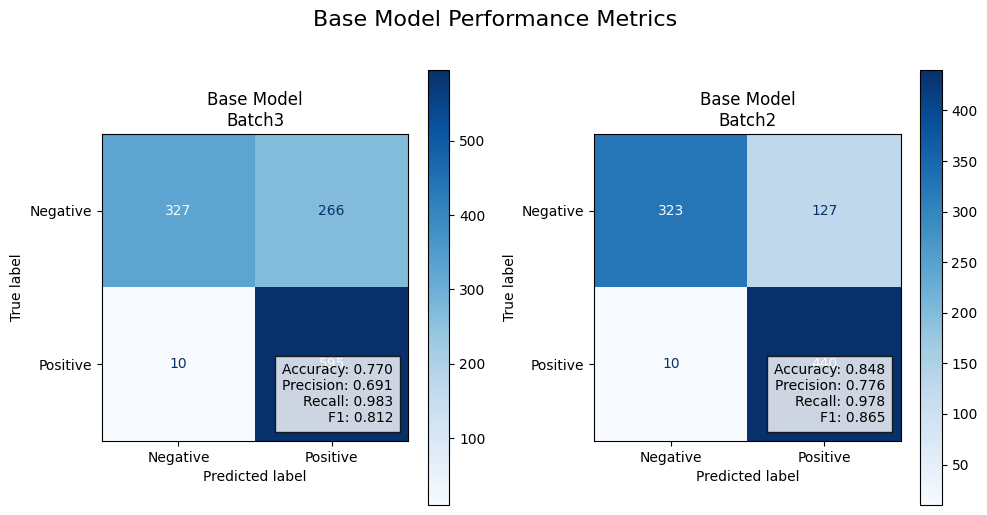


Base Model Overall Performance:
Accuracy: 0.8031
Precision: 0.7248
Recall: 0.9810
F1_score: 0.8337
Auc: 0.9007
Confusion_matrix: [[ 650  393]
 [  20 1035]]


In [140]:
print("\n========== BASE MODEL EVALUATION ON TEST DATA==========")
base_results, base_predictions = evaluate_model(base_model_path, return_predictions=True)
display_batch_results(base_results, "Base Model")
plot_performance_matrix(base_results, "Base Model")

### **Robustness Test**


========== BASE MODEL ROBUSTNESS TESTS ==========
Evaluating robustness for transform: translation
Total samples loaded: 2098
  Results for Batch3 with translation transform:
    accuracy: 0.6503
    precision: 0.5915
    recall: 0.9934
    f1_score: 0.7415
    auc: 0.8730
  Results for Batch2 with translation transform:
    accuracy: 0.7389
    precision: 0.6579
    recall: 0.9956
    f1_score: 0.7922
    auc: 0.9031
Overall results for translation:
  accuracy: 0.6883
  precision: 0.6181
  recall: 0.9943
  f1_score: 0.7624
  auc: 0.8836
Evaluating robustness for transform: rotation
Total samples loaded: 2098
  Results for Batch3 with rotation transform:
    accuracy: 0.6244
    precision: 0.5739
    recall: 0.9950
    f1_score: 0.7279
    auc: 0.8685
  Results for Batch2 with rotation transform:
    accuracy: 0.7056
    precision: 0.6308
    recall: 0.9911
    f1_score: 0.7710
    auc: 0.8952
Overall results for rotation:
  accuracy: 0.6592
  precision: 0.5968
  recall: 0.9934
  f1_s

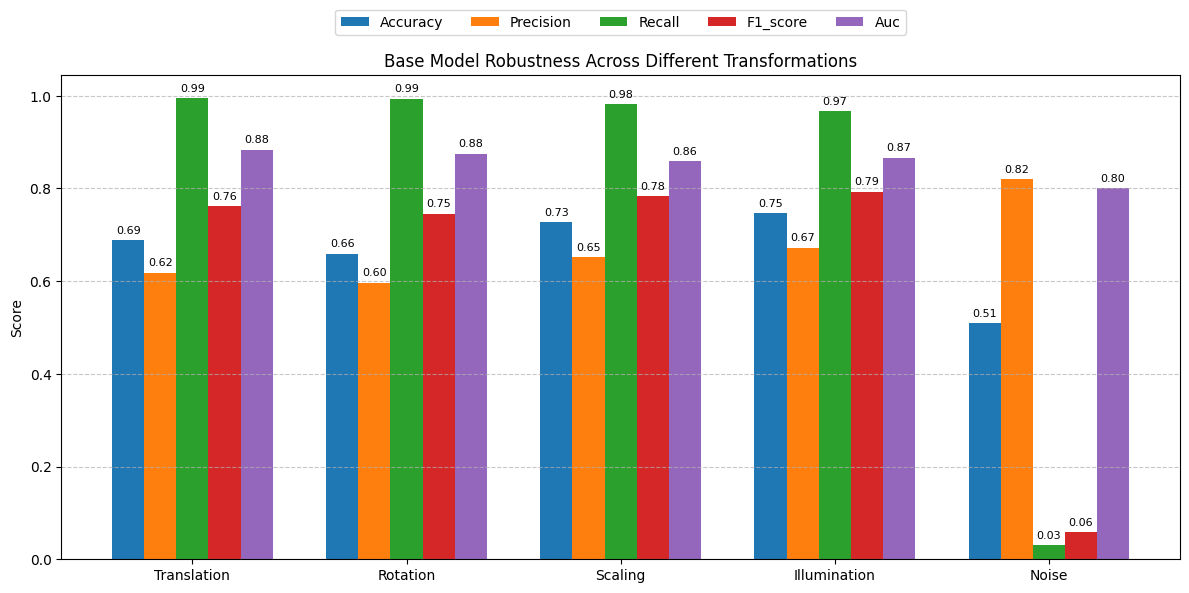

In [141]:
print("\n========== BASE MODEL ROBUSTNESS TESTS ==========")
base_robust_results, base_robust_predictions = evaluate_robustness(base_model_path,batch_size=2048,return_predictions=True)
display_robustness_results(base_robust_results, "Base Model")

Based on the results and error analysis, We can see clear issues in our model's performance when transitioning from individual to grouped seed classification under different lighting conditions. Here's how we would fine-tune the model and why these approaches would help:

Training on individual seeds but testing on grouped seeds (domain shift)
Very high false positive rate (95.2%)
Poor performance under transformations, especially noise
Worse performance in light box conditions (Batch3)

### **Fine Tuning**

In [216]:
fine_tuned_path = fine_tune_model(data_root, "base.pth", num_epochs=15)

Using device: cuda
Class distribution: [851, 901]
Using class weights: [1.3725029230117798, 0.7778024673461914]
Training dataset size: 2103
Validation dataset size: 350
Starting fine-tuning process...
Epoch 1/15 — Train Loss: 0.3184 | Train Acc: 0.9157 | Train F1: 0.9519 | Val Loss: 0.0159 | Val Acc: 0.9943 | Val F1: 0.9943
Validation Confusion Matrix:
[[164   1]
 [  1 184]]
Precision: 0.9946, Recall: 0.9946
False Positives: 1, False Negatives: 1
New best model saved! (F1: 0.9943)
Optimal confidence threshold: 0.2189 (Precision: 0.9946, Recall: 1.0000)
Epoch 2/15 — Train Loss: 0.2407 | Train Acc: 0.9284 | Train F1: 0.9658 | Val Loss: 0.0347 | Val Acc: 0.9971 | Val F1: 0.9971
Validation Confusion Matrix:
[[165   0]
 [  1 184]]
Precision: 1.0000, Recall: 0.9946
False Positives: 0, False Negatives: 1
New best model saved! (F1: 0.9971)
Optimal confidence threshold: 0.4836 (Precision: 1.0000, Recall: 1.0000)
Epoch 3/15 — Train Loss: 0.1634 | Train Acc: 0.9510 | Train F1: 0.9775 | Val Loss: 

### **Evaluation on fine tuned model**


========== FINE-TUNED MODEL EVALUATION ON TEST DATA ==========
Total samples loaded: 2098
Starting evaluation on combined dataset with 2098 samples...
Processing batch 10/33
Processing batch 20/33
Processing batch 30/33
Completed evaluation, calculating metrics...
Results for Batch3:
  accuracy: 0.7813
  precision: 0.7069
  recall: 0.9686
  f1_score: 0.8173
  auc: 0.8846
  Confusion Matrix:
[[350 243]
 [ 19 586]]
Results for Batch2:
  accuracy: 0.8789
  precision: 0.8199
  recall: 0.9711
  f1_score: 0.8891
  auc: 0.9511
  Confusion Matrix:
[[354  96]
 [ 13 437]]
Calculating overall metrics...
Overall results:
  accuracy: 0.8232
  precision: 0.7511
  recall: 0.9697
  f1_score: 0.8465
  auc: 0.9130
  Confusion Matrix:
[[ 704  339]
 [  32 1023]]

========== ERROR ANALYSIS ==========
Error distribution by batch:
  Batch2: 109 errors (29.4%)
  Batch3: 262 errors (70.6%)

False positives: 339 (91.4%)
False negatives: 32 (8.6%)

False positive average confidence: 0.8026
False negative averag

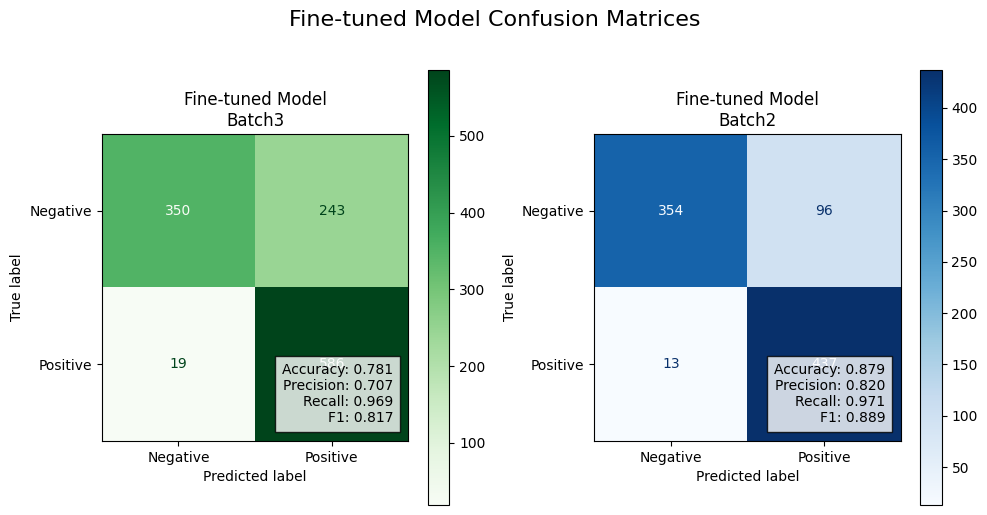

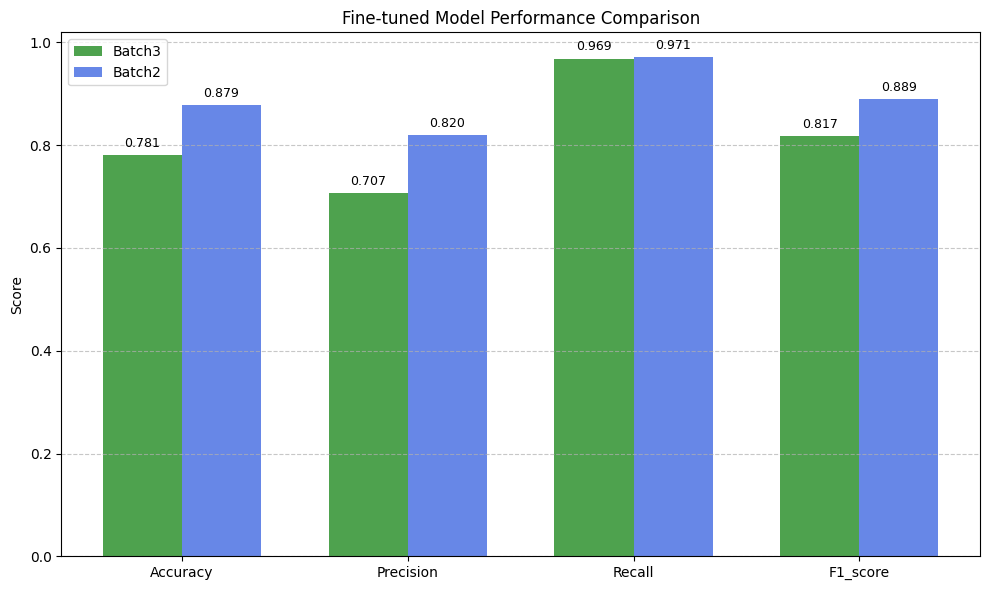

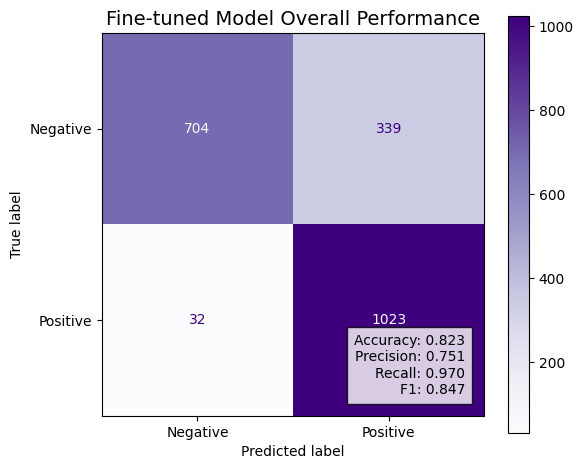

In [217]:
fine_tuned_results, fine_predictions = evaluate_model(fine_tuned_path, return_predictions=True)
display_batch_results(fine_tuned_results, "Fine-tuned Model")
plot_performance_matrix(fine_tuned_results, "Fine-tuned Model")


========== FINE-TUNED MODEL ROBUSTNESS TESTS ==========
Evaluating robustness for transform: translation
Total samples loaded: 2098
  Processing batch 10/33
  Processing batch 20/33
  Processing batch 30/33
  Results for Batch3 with translation transform:
    accuracy: 0.7796
    precision: 0.7062
    recall: 0.9653
    f1_score: 0.8156
    auc: 0.8786
  Results for Batch2 with translation transform:
    accuracy: 0.8644
    precision: 0.7960
    recall: 0.9800
    f1_score: 0.8785
    auc: 0.9448
Overall results for translation:
  accuracy: 0.8160
  precision: 0.7422
  recall: 0.9716
  f1_score: 0.8415
  auc: 0.9094
Evaluating robustness for transform: rotation
Total samples loaded: 2098
  Processing batch 10/33
  Processing batch 20/33
  Processing batch 30/33
  Results for Batch3 with rotation transform:
    accuracy: 0.7045
    precision: 0.6325
    recall: 0.9901
    f1_score: 0.7719
    auc: 0.8711
  Results for Batch2 with rotation transform:
    accuracy: 0.8356
    precision:

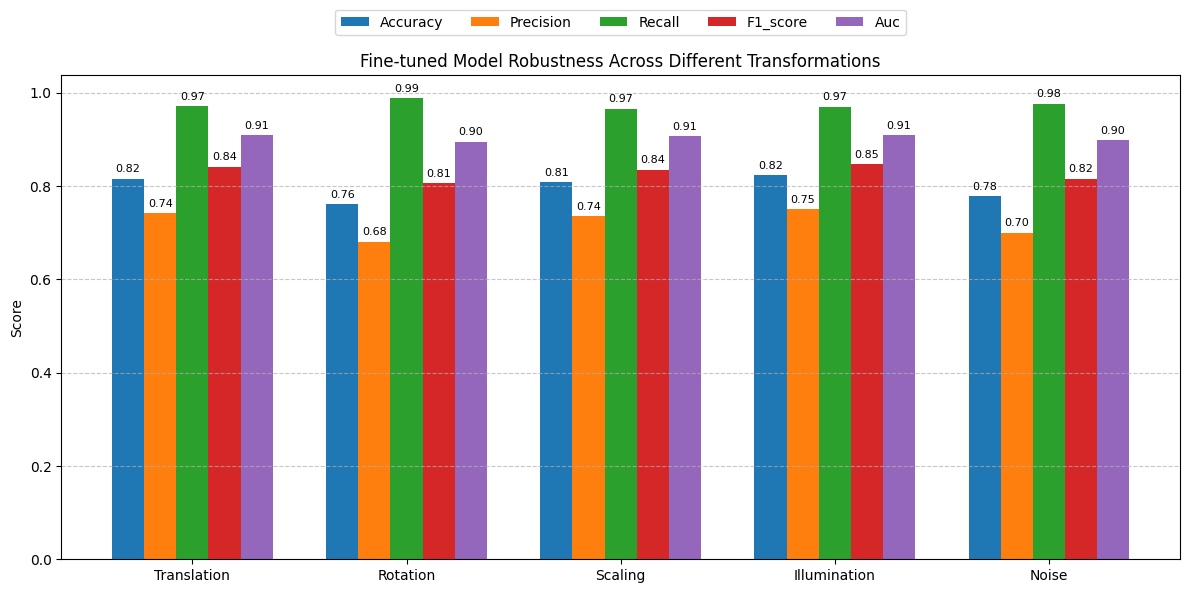

In [219]:
print("\n========== FINE-TUNED MODEL ROBUSTNESS TESTS ==========")
fine_tuned_robust_results, fine_tuned_robust_predictions = evaluate_robustness(fine_tuned_path,
                                                                                   threshold=0.5,
                                                                                   return_predictions=True)
display_robustness_results(fine_tuned_robust_results, "Fine-tuned Model")

Total samples loaded: 2098
Starting evaluation on combined dataset with 2098 samples...
Processing batch 10/33
Processing batch 20/33
Processing batch 30/33
Completed evaluation, calculating metrics...
Results for Batch3:
  accuracy: 0.7696
  precision: 0.6911
  recall: 0.9835
  f1_score: 0.8117
  auc: 0.8906
  Confusion Matrix:
[[327 266]
 [ 10 595]]
Results for Batch2:
  accuracy: 0.8478
  precision: 0.7760
  recall: 0.9778
  f1_score: 0.8653
  auc: 0.9202
  Confusion Matrix:
[[323 127]
 [ 10 440]]
Calculating overall metrics...
Overall results:
  accuracy: 0.8031
  precision: 0.7248
  recall: 0.9810
  f1_score: 0.8337
  auc: 0.9007
  Confusion Matrix:
[[ 650  393]
 [  20 1035]]

========== ERROR ANALYSIS ==========
Error distribution by batch:
  Batch2: 137 errors (33.2%)
  Batch3: 276 errors (66.8%)

False positives: 393 (95.2%)
False negatives: 20 (4.8%)

False positive average confidence: 0.9183
False negative average confidence: 0.8928

Error cases saved to 'error_analysis.csv'


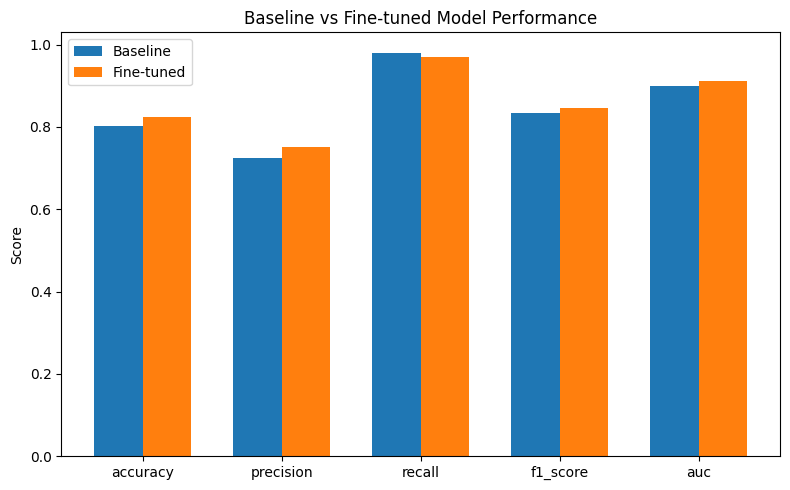

Metric improvements (Fine-tuned − Baseline):
  accuracy: +0.0200
  precision: +0.0263
  recall: -0.0114
  f1_score: +0.0128
  auc: +0.0123


In [222]:
base_results = evaluate_model(base_model_path)
fine_results = evaluate_model(fine_tuned_path)

metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
base_vals = [base_results['overall'][m] for m in metrics]
fine_vals = [fine_results['overall'][m] for m in metrics]
improvements = [fine - base for fine, base in zip(fine_vals, base_vals)]

import matplotlib.pyplot as plt

x = range(len(metrics))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar([i - width/2 for i in x], base_vals, width, label='Baseline')
plt.bar([i + width/2 for i in x], fine_vals, width, label='Fine-tuned')
plt.xticks(x, metrics)
plt.ylabel('Score')
plt.title('Baseline vs Fine-tuned Model Performance')
plt.legend()
plt.tight_layout()
plt.show()

# Print numeric improvements
print("Metric improvements (Fine-tuned − Baseline):")
for m, imp in zip(metrics, improvements):
    print(f"  {m}: {imp:+.4f}")


### **Visualize Comparison**

Evaluating robustness for transform: translation
Total samples loaded: 2098
  Processing batch 10/33
  Processing batch 20/33
  Processing batch 30/33
  Results for Batch3 with translation transform:
    accuracy: 0.6486
    precision: 0.5906
    recall: 0.9917
    f1_score: 0.7403
    auc: 0.8823
  Results for Batch2 with translation transform:
    accuracy: 0.7367
    precision: 0.6564
    recall: 0.9933
    f1_score: 0.7905
    auc: 0.8930
Overall results for translation:
  accuracy: 0.6864
  precision: 0.6170
  recall: 0.9924
  f1_score: 0.7609
  auc: 0.8844
Evaluating robustness for transform: rotation
Total samples loaded: 2098
  Processing batch 10/33
  Processing batch 20/33
  Processing batch 30/33
  Results for Batch3 with rotation transform:
    accuracy: 0.6285
    precision: 0.5766
    recall: 0.9950
    f1_score: 0.7301
    auc: 0.8605
  Results for Batch2 with rotation transform:
    accuracy: 0.7300
    precision: 0.6507
    recall: 0.9933
    f1_score: 0.7863
    auc: 

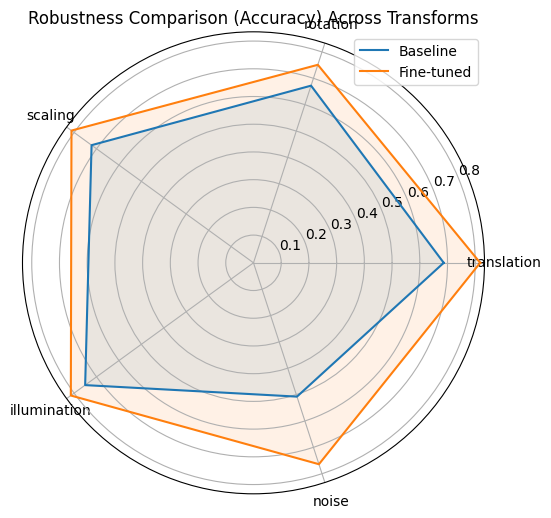

In [223]:
# Evaluate robustness for baseline and fine-tuned models
base_robust = evaluate_robustness(base_model_path, threshold=0.5)
fine_robust = evaluate_robustness(fine_tuned_path, threshold=0.5)

transforms_list = list(base_robust.keys())
base_acc = [base_robust[t]['accuracy'] for t in transforms_list]
fine_acc = [fine_robust[t]['accuracy'] for t in transforms_list]

angles = np.linspace(0, 2 * np.pi, len(transforms_list), endpoint=False).tolist()
angles += angles[:1]
base_acc += base_acc[:1]
fine_acc += fine_acc[:1]

# Plot radar chart
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, base_acc, label='Baseline')
ax.fill(angles, base_acc, alpha=0.1)
ax.plot(angles, fine_acc, label='Fine-tuned')
ax.fill(angles, fine_acc, alpha=0.1)

# Set the labels and title
ax.set_thetagrids(np.degrees(angles[:-1]), transforms_list)
ax.set_title('Robustness Comparison (Accuracy) Across Transforms')
ax.legend(loc='upper right')
plt.show()

### **Sample Analysis Visualisation**

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


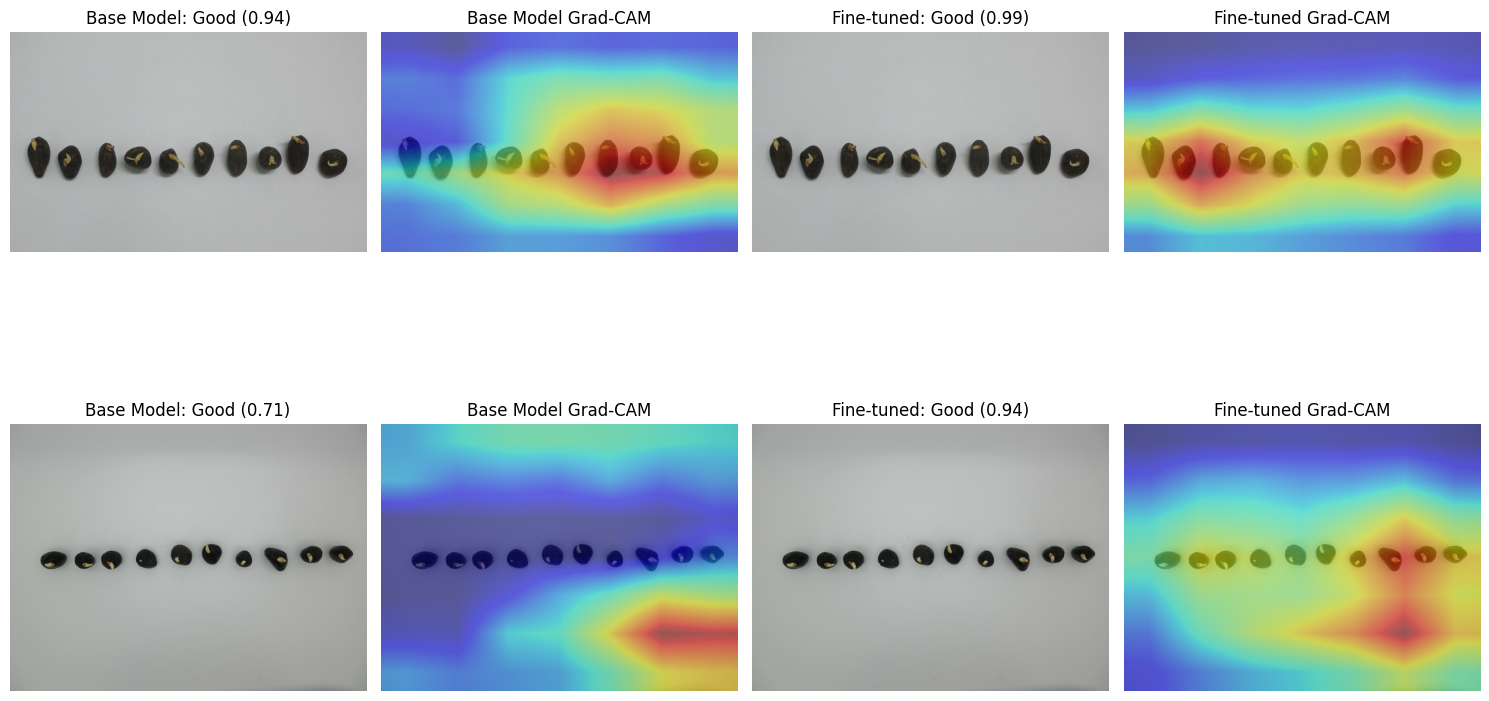

In [227]:
import cv2
batch2_sample_path = '/content/drive/MyDrive/Computer_Vision/Batch2/Set1/Line_Bad_Seeds (s1).JPG'
batch3_sample_path = '/content/drive/MyDrive/Computer_Vision/Batch3/Set1/Line_BadSeeds (s1).JPG'

# Load models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Base model
base_model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
base_model.fc = torch.nn.Linear(base_model.fc.in_features, 2)
base_model.load_state_dict(torch.load(base_model_path, map_location=device))
base_model.to(device)
base_model.eval()

# Fine-tuned model
fine_tuned_model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
fine_tuned_model.fc = torch.nn.Linear(fine_tuned_model.fc.in_features, 2)
fine_tuned_model.load_state_dict(torch.load(fine_tuned_path, map_location=device))
fine_tuned_model.to(device)
fine_tuned_model.eval()

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load and process sample images
batch2_img = Image.open(batch2_sample_path).convert('RGB')
batch3_img = Image.open(batch3_sample_path).convert('RGB')

batch2_tensor = transform(batch2_img).unsqueeze(0).to(device)
batch3_tensor = transform(batch3_img).unsqueeze(0).to(device)

# Get predictions
with torch.no_grad():
    # Batch 2 predictions
    base_out_batch2 = base_model(batch2_tensor)
    fine_out_batch2 = fine_tuned_model(batch2_tensor)

    # Batch 3 predictions
    base_out_batch3 = base_model(batch3_tensor)
    fine_out_batch3 = fine_tuned_model(batch3_tensor)

# Convert outputs to probabilities and labels
base_prob_batch2 = F.softmax(base_out_batch2, dim=1)[0][1].item()
fine_prob_batch2 = F.softmax(fine_out_batch2, dim=1)[0][1].item()

base_prob_batch3 = F.softmax(base_out_batch3, dim=1)[0][1].item()
fine_prob_batch3 = F.softmax(fine_out_batch3, dim=1)[0][1].item()

base_label_batch2 = "Good" if base_prob_batch2 > 0.5 else "Bad"
fine_label_batch2 = "Good" if fine_prob_batch2 > 0.5 else "Bad"

base_label_batch3 = "Good" if base_prob_batch3 > 0.5 else "Bad"
fine_label_batch3 = "Good" if fine_prob_batch3 > 0.5 else "Bad"

# Grad-CAM visualization
def get_gradcam(model, img_tensor, target_layer='layer4'):
    # Get the feature maps from the target layer
    features = None
    gradients = None

    def hook_features(module, input, output):
        nonlocal features
        features = output

    def hook_grads(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0]

    # Register hooks
    for name, module in model.named_modules():
        if name == target_layer:
            module.register_forward_hook(hook_features)
            module.register_full_backward_hook(hook_grads)

    # Forward pass
    output = model(img_tensor)

    # Clear any existing gradients
    model.zero_grad()

    # Backward pass
    output[:, 1].backward()  # Target class 1 (Good)

    # Calculate weights
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # Weight the feature maps with the gradient weights
    for i in range(features.size()[1]):
        features[:, i, :, :] *= pooled_gradients[i]

    # Generate heatmap
    heatmap = torch.mean(features, dim=1).squeeze().detach().cpu().numpy()
    heatmap = np.maximum(heatmap, 0)  # ReLU
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)  # Normalize

    return heatmap

# Get heatmaps
base_heatmap_batch2 = get_gradcam(base_model, batch2_tensor)
fine_heatmap_batch2 = get_gradcam(fine_tuned_model, batch2_tensor)
base_heatmap_batch3 = get_gradcam(base_model, batch3_tensor)
fine_heatmap_batch3 = get_gradcam(fine_tuned_model, batch3_tensor)

# Visualize results
plt.figure(figsize=(15, 10))

# Batch 2 visualization
plt.subplot(2, 4, 1)
plt.imshow(np.array(batch2_img))
plt.title(f"Base Model: {base_label_batch2} ({base_prob_batch2:.2f})")
plt.axis('off')

plt.subplot(2, 4, 2)
plt.imshow(np.array(batch2_img))
plt.imshow(cv2.resize(base_heatmap_batch2, (batch2_img.width, batch2_img.height)), alpha=0.5, cmap='jet')
plt.title("Base Model Grad-CAM")
plt.axis('off')

plt.subplot(2, 4, 3)
plt.imshow(np.array(batch2_img))
plt.title(f"Fine-tuned: {fine_label_batch2} ({fine_prob_batch2:.2f})")
plt.axis('off')

plt.subplot(2, 4, 4)
plt.imshow(np.array(batch2_img))
plt.imshow(cv2.resize(fine_heatmap_batch2, (batch2_img.width, batch2_img.height)), alpha=0.5, cmap='jet')
plt.title("Fine-tuned Grad-CAM")
plt.axis('off')

# Batch 3 visualization
plt.subplot(2, 4, 5)
plt.imshow(np.array(batch3_img))
plt.title(f"Base Model: {base_label_batch3} ({base_prob_batch3:.2f})")
plt.axis('off')

plt.subplot(2, 4, 6)
plt.imshow(np.array(batch3_img))
plt.imshow(cv2.resize(base_heatmap_batch3, (batch3_img.width, batch3_img.height)), alpha=0.5, cmap='jet')
plt.title("Base Model Grad-CAM")
plt.axis('off')

plt.subplot(2, 4, 7)
plt.imshow(np.array(batch3_img))
plt.title(f"Fine-tuned: {fine_label_batch3} ({fine_prob_batch3:.2f})")
plt.axis('off')

plt.subplot(2, 4, 8)
plt.imshow(np.array(batch3_img))
plt.imshow(cv2.resize(fine_heatmap_batch3, (batch3_img.width, batch3_img.height)), alpha=0.5, cmap='jet')
plt.title("Fine-tuned Grad-CAM")
plt.axis('off')

plt.tight_layout()
plt.show()